# 統計数理研究所リーディングDAT2017 LB1課題
課題概要：
* 自由に選んだ国について、訪日外客数の月次推移の予測を行う
* 2003年〜2016年のデータを使用し、2017年の訪問者数を予測する
* モデルの良し悪しはAICを基準とする
* モデルには以下を考慮する
    * カレンダー効果（曜日効果・うるう年効果）の影響
    * 外れ値

In [300]:
# library(plotly)
library(tidyverse)
library(KFAS)
# source("./kfas_helper.r")

In [301]:
# helper functions definition
library(KFAS)

calc_log_likelihood <- function(kfs){
    # calculate log likelihood
    #  NOTE: second term: modify term (Durbin and Koopman,2012)
    ll <- kfs$logLik - sum(kfs$Finf>0) * log(2*pi)/2
    return(ll)
}

calc_AIC_from_ll <- function(ll,mod){
    # calculate AIC using log likelihood & model
    #     AIC = -2 * maximum likelihood +
    #     2 * (number of unknown params + number of dynamic states)

    # number of params
    num_p <- sum(is.na(mod$Q)) + 1
    # number of states
    num_s <- length(mod$a1)
    aic <- -2*ll + 2*(num_p + num_s)
    return(aic)
}

calc_AIC <- function(kfs,mod){
    # calculate AIC
    # input :
    #  kfs : KFS object
    #  mod : model before parameters optimization
    ll <- calc_log_likelihood(kfs)
    aic <- calc_AIC_from_ll(ll,mod)
    return(aic)
}

calc_AICs <- function(kfss,mods){
  n_mods <- length(mods)
  aics <- vector()
  for(i in 1:n_mods){
    aics[i] <- calc_AIC(kfs[[i]],mods[[i]])
  }
  return(aics)
}

select_best_model <- function(kfss,mods){
  # return best model which minimize AIC
  n_mods <- length(mods)

  aics <- vector()
  for(i in 1:n_mods){
    aic <- calc_AIC(kfss[[i]],mods[[i]])
    aics[i] <- aic
  }
  best_idx <- which(aics == min(aics))
  return(list(best_index=best_idx,model=mods[[best_idx]]))
}

get_standardized_error <- function(kfs){
  # get standardized error

  obs_err <- rstandard(kfs,"pearson")
  state_err <- rstandard(kfs,"state")
  return(cbind(obs_err,state_err))
}


fit_wrapper <- function(mod,method="BFGS"){
  num_p <- sum(is.na(mod$Q)) + 1
  fit <- fitSSM(mod,numeric(num_p),method=method)
  return(fit)
}

get_models <- function(fits){
  n_fits <- length(fits)
  mods <- list()
  for(i in 1:n_fits){
    mods[[i]] <- fits[[i]]$model
  }
  return(mods)
}

get_calendar <- function(start,end){
  dates <- seq(as.Date(start),as.Date(end),by=1)
  weeks <- table(substr(dates,1,7),weekdays(dates,T))
  sun <- weeks[,"日"]
  mon <- weeks[,"月"]-sun; tue <- weeks[,"火"]-sun; wed <- weeks[,"水"]-sun
  thu <- weeks[,"木"]-sun; fry <- weeks[,"金"]-sun; sat <- weeks[,"土"]-sun
  calendar <- cbind(mon, tue, wed, thu, fry, sat)


  monthyear <- rownames(weeks)

  leapyear <- rep(F,length(monthyear))
  years <- as.numeric(substr(monthyear,1,4))
  feb_idx <- grep("-02",monthyear)
  not_leapyear_idx <- which(years%%4 != 0)

  leapyear[feb_idx] <- T
  leapyear[not_leapyear_idx] <- F

  return(list(calendar=calendar,leapyear=leapyear))
}

## メモ
# 予測：predict("confidence")
# ローカルレベル推定量：kfs$alphahat[,"level"]
# スロープ推定量：kfs$alphahat[,"slope"]
# error: rstandard


## データ概要把握

### データ読み込み

In [302]:
df <- read_csv("number_of_guests.csv",locale=locale(encoding="SJIS"))
head(df)

Parsed with column specification:
cols(
  .default = col_integer(),
  年月 = col_character()
)
See spec(...) for full column specifications.


年月,総数,中国,香港,台湾,韓国,フィリピン,タイ,シンガポール,マレーシア,...,インド,ベトナム,英国,ドイツ,フランス,ロシア,イタリア,米国,カナダ,豪州
2003年1月,450847,40824,23793,68464,147238,10224,4020,4112,4218,...,4238,1086,16746,6065,6445,2484,2357,50765,11587,15405
2003年2月,394869,41864,25924,66734,112988,8728,4252,4522,4525,...,2994,1130,14308,6655,6748,2780,2227,42567,9300,10967
2003年3月,456614,49676,18437,64225,108871,12081,8970,6682,6417,...,4291,1657,20696,10711,8747,3323,3538,63847,12650,13170
2003年4月,354054,42706,10703,46418,87477,12196,7836,3259,4743,...,2884,1483,17783,7710,6829,3298,2403,45911,8253,11959
2003年5月,288562,11280,11195,16983,92072,10988,5342,2845,3685,...,4164,928,14198,7005,5762,3675,2202,46380,7499,12420
2003年6月,352431,12915,22778,28174,109379,10103,4877,6897,4069,...,4282,1207,13361,5956,5775,3804,2500,59716,8632,14467


In [303]:
# 年月
datetime <- paste0(df$年月,"1日") %>% as.Date(format="%Y年%m月%d日")
df$年月 <- datetime
# 総数
total <- df$総数
# それ以外のデータ
dat <- df[,c(-1,-2)]

df_log <- df
df_log[,-1] <- log(df_log[,-1])
# 総数(log)
total_log <- log(total)
# それ以外のデータ(log)
dat_log <- log(dat)

### プロット

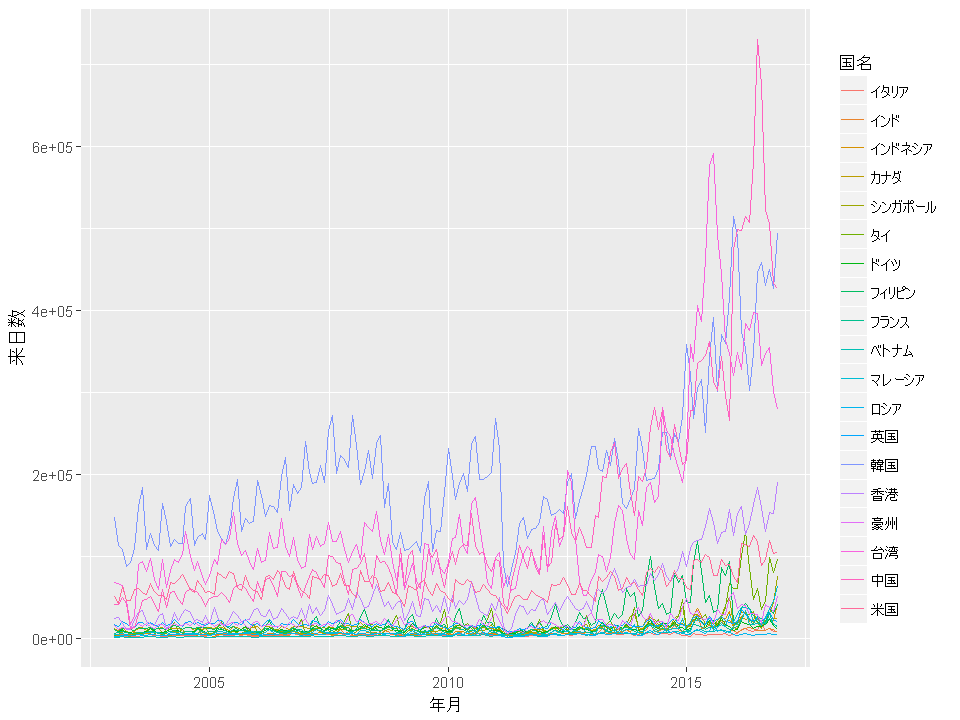

In [304]:
# トレンド
options(repr.plot.width=8, repr.plot.height=6)
p <- ggplot(gather(df[,-2],国名,来日数,-年月),aes(x = 年月, y = 来日数, colour=国名)) + geom_line()

print(p)

* 以下のイベントに対してトレンドの大きな落ち込みが見られる
    * 2008年：リーマンショック  
    * 2011年：東日本大震災
* １２ヶ月を１周期とする周期性が見られる。変動幅は訪問者数の規模に応じて変化している

# モデル作成

* 予測対象は米国の2017年とする
* まずは幾つかのモデルを適当に作成し、その中でAIC最小モデルの結果をプロットしてみる
* モデルの作成方針：
    * 周期性が観察されるため、季節変動成分をモデルに加える
    * 2012年以降、トレンドは上昇傾向にあるため、平滑化トレンドモデルを採用する
    * 説明変数はカレンダーのみ考慮
    * 観測値はカウント値で上限がないため、観測値がポアソン分布から生成されるモデルが考えられる。  
      しかしトレンドグラフより平均≠分散であることが伺えるため、観測値の対数が正規分布に従うモデルを採用する

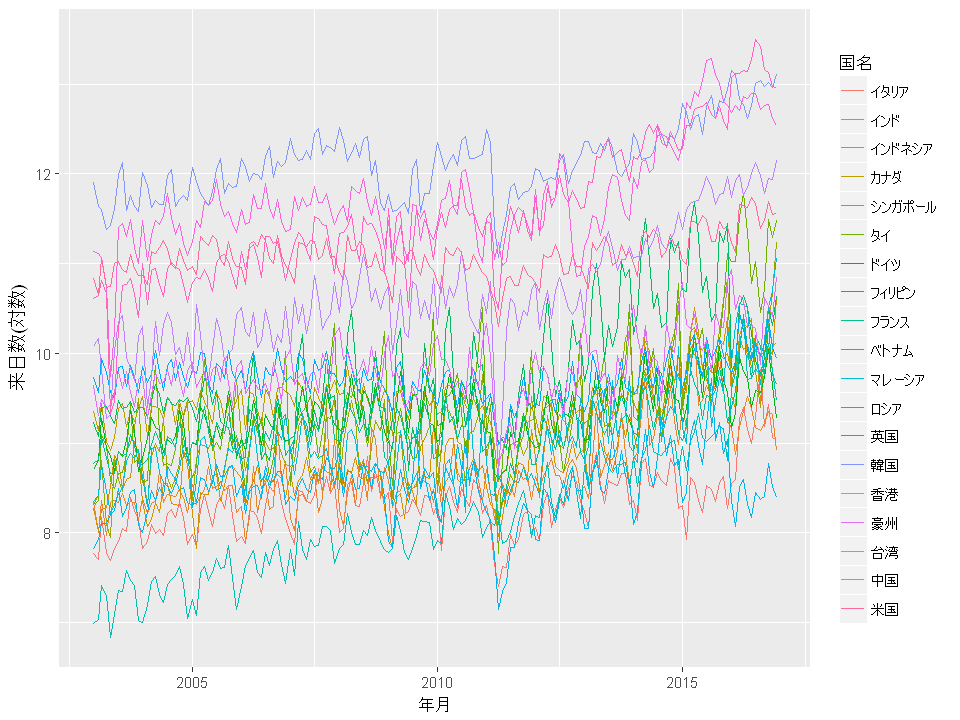

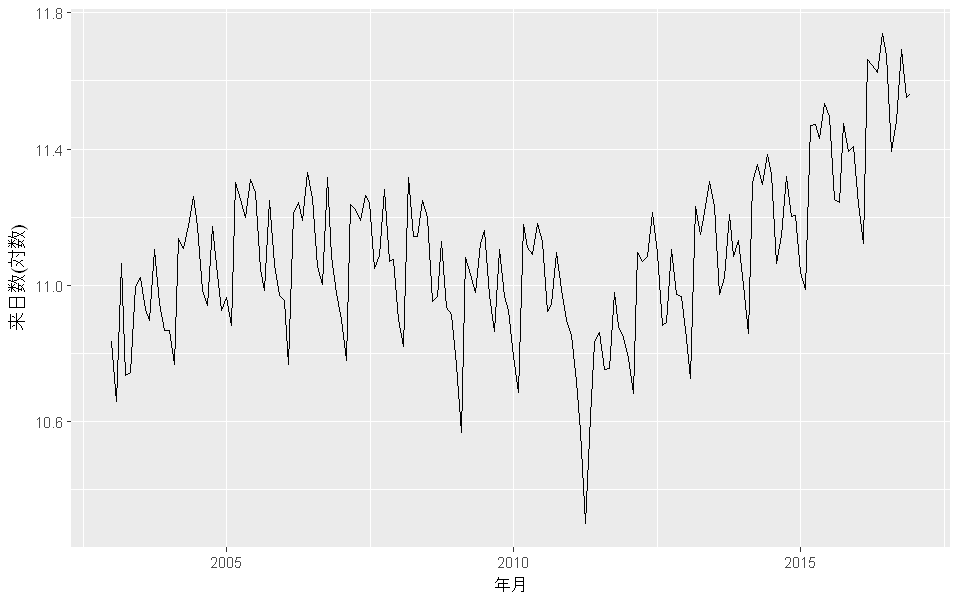

In [305]:
# 対数トレンド
options(repr.plot.width=8, repr.plot.height=6)
ggplot(gather(df_log[,-2],国名,来日数,-年月),aes(x=年月,y=来日数,colour=国名)) + geom_line() + ylab("来日数(対数)")
# 米国のみ
options(repr.plot.width=8, repr.plot.height=5)
ggplot(df_log,aes(x=年月,y=米国)) + geom_line() + ylab("来日数(対数)")

* 対数をとることで、周期性の変動幅が揃った

### モデルの比較

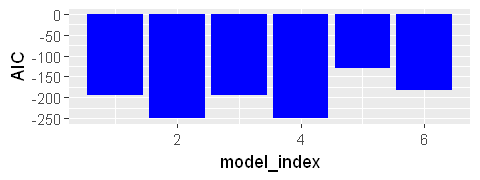

[1] "AIC最小モデル： 2"


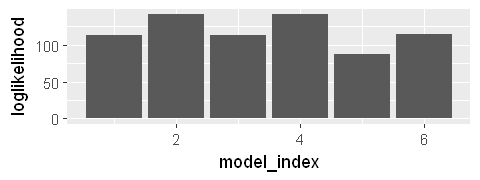

In [306]:
# 年月付与
datetime.NA <- c(datetime,seq(as.Date("2017-01-01"), as.Date("2017-12-01"), by="months"))

# 目的変数
obj <- df_log$米国
# 予測対象期間にNAを付与
obj.NA <- c(obj,rep(NA,12))

# 説明変数
calendar <- get_calendar(datetime.NA[1],datetime.NA[length(datetime.NA)])  #カレンダー

# モデル
mods <- list(
    # １：平滑化トレンド(水準変動なし)＋周期性(季節変動なし)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=0),H=NA),
    # ２：平滑化トレンド(水準変動あり)＋周期性(季節変動なし)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=0),H=NA),
    # ３：平滑化トレンド(水準変動なし)＋周期性(季節変動あり)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA),H=NA),
    # ４：平滑化トレンド(水準変動あり)＋周期性(季節変動あり)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA),H=NA),
    # ５：平滑化トレンド(水準変動なし)＋周期性(季節変動なし)＋カレンダー成分
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=0) + calendar$calendar + calendar$leapyear,H=NA),
    # ６：平滑化トレンド(水準変動あり)＋周期性(季節変動なし)＋カレンダー成分
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=0) + calendar$calendar + calendar$leapyear,H=NA)
)

# パラメータ推定
fits <- lapply(mods,fit_wrapper,method="BFGS")
mods.fit <- get_models(fits)
# カルマンスムージング
kfs <- lapply(mods.fit,KFS,smoothing=c("state","mean","disturbance"))

# 対数尤度
lls <- lapply(kfs,calc_log_likelihood) %>% as.numeric
# AIC
aics <- calc_AICs(kfs,mods)
# AIC最小モデル
best_idx <- select_best_model(kfs,mods)$best_index

# 尤度、AICのプロット
options(repr.plot.width=4, repr.plot.height=1.5)
goodness <- data.frame(model_index=1:length(mods),AIC=aics,loglikelihood=lls)
p <- ggplot(goodness) + geom_bar(aes(x=model_index,y=AIC),stat="identity",fill="blue")
print(p)
p <- ggplot(goodness) + geom_bar(aes(x=model_index,y=loglikelihood),stat="identity")
print(p)
paste0("AIC最小モデル： ",best_idx) %>% print

* 以下２つのモデルが良さそうである
    1. **平滑化トレンド(水準変動あり)＋周期性(季節変動なし)**
    2. 平滑化トレンド(水準変動あり)＋周期性(季節変動あり)
* 僅差で**季節変動なし**の方が選ばれている
* カレンダー効果を加えたケースではAICが悪化しており、**カレンダーの影響は薄い**と考えられる

In [307]:
#　信頼区間(状態)
best.conf <- predict(mods.fit[[best_idx]],interval="confidence",level=.95)
# 信頼区間(観測値)
best.predict <- predict(mods.fit[[best_idx]],interval="prediction",level=.95)
# 残差
best.error <- get_standardized_error(kfs[[best_idx]])

### 結果のプロット

Warning message:
"Removed 12 rows containing missing values (geom_point)."

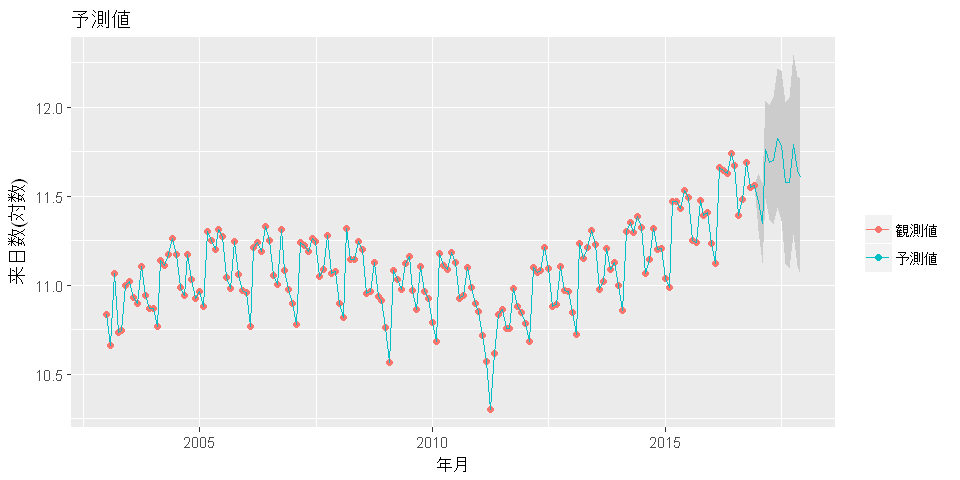

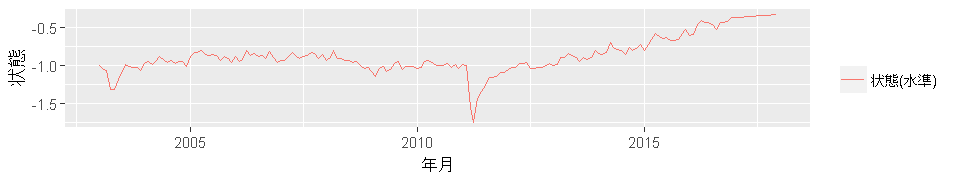

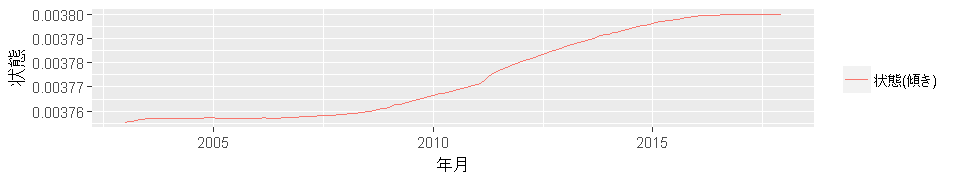

Warning message:
"Removed 12 rows containing missing values (geom_path)."

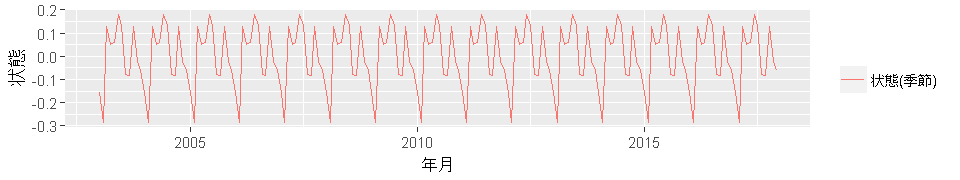

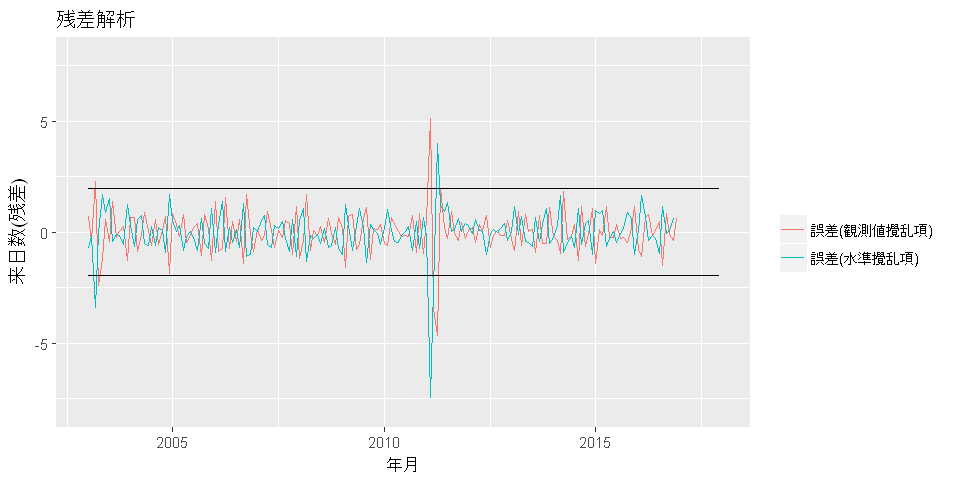

In [308]:
# ベストモデルの情報を含むdata.frameを作成
df.best <- data.frame(年月=datetime.NA,観測値=obj.NA,best.conf,best.predict,best.error,kfs[[best_idx]]$alphahat,
                    x=c(-Inf,Inf),lb=-1.96,ub=1.96)
# 予測値
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best,aes(x=年月)) + 
    geom_ribbon(aes(ymin=lwr.1,ymax=upr.1),fill="grey90") +
    geom_ribbon(aes(ymin=lwr,ymax=upr),fill="grey80") +
    geom_point(aes(y=観測値,color="観測値")) +
    geom_line(aes(y=fit,color="予測値")) +
    xlab("年月") + ylab("来日数(対数)") + ggtitle("予測値") + labs(color="")

# 状態変化
options(repr.plot.width=8, repr.plot.height=1.5)
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=level-12,color="状態(水準)")) + ylab("状態") + labs(color="")
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=slope,color="状態(傾き)")) + ylab("状態") + labs(color="")
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=sea_dummy1,color="状態(季節)")) + ylab("状態") + labs(color="")

# 残差解析
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best,aes(x=年月)) + 
    geom_line(aes(y=state_err.level,color="誤差(水準攪乱項)")) + 
    geom_line(aes(y=obs_err,color="誤差(観測値攪乱項)")) + 
    geom_line(aes(y=state_err.level,color="誤差(水準攪乱項)")) + 
    geom_line(aes(y=lb)) + geom_line(aes(y=ub)) + 
    xlab("年月") + ylab("来日数(残差)") + ggtitle("残差解析") + labs(color="") + ylim(-8,8)

* 2011年2月〜同年4月において大きな外れ値が確認できる（東日本大震災の影響）
* リーマンショックの影響は小さい

In [309]:
print("観測誤差分散")
mods.fit[[best_idx]]$H %>% print
print("状態誤差分散")
mods.fit[[best_idx]]$Q %>% print

[1] "観測誤差分散"
, , 1

             [,1]
[1,] 5.732409e-07

[1] "状態誤差分散"
, , 1

            [,1]         [,2] [,3]
[1,] 0.006181375 0.000000e+00    0
[2,] 0.000000000 7.474087e-09    0
[3,] 0.000000000 0.000000e+00    0



観測誤差分散は非常に小さく、水準の変動が大きなモデルとなっている

# 外れ値除去モデル
* 下記の対処により精度の向上をめざす
    * 大震災の影響による外れ値を除去
    * 説明変数（地震）の追加

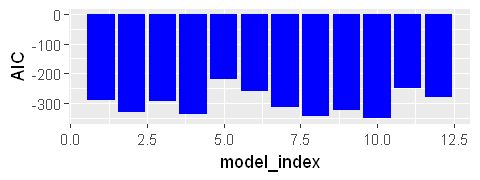

[1] "AIC最小モデル： 10"


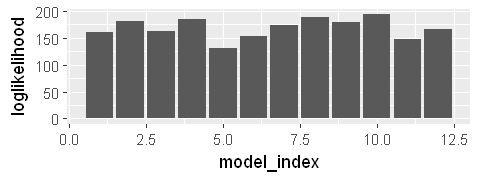

In [310]:
# 外れ値の箇所にNA
outlier_idx <- which(datetime.NA %in% c(as.Date(c("2011-02-01","2011-03-01","2011-04-01"))))
obj.NA[outlier_idx] <- NA

# 説明変数(地震)
eq <- numeric(length(datetime.NA))
eq [datetime.NA >= as.Date("2011-03-01")] <- 1

# モデル
mods <- list(
    # １：平滑化トレンド(水準変動なし)＋周期性(季節変動なし)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=0),H=NA),
    # ２：平滑化トレンド(水準変動あり)＋周期性(季節変動なし)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=0),H=NA),
    # ３：平滑化トレンド(水準変動なし)＋周期性(季節変動あり)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA),H=NA),
    # ４：平滑化トレンド(水準変動あり)＋周期性(季節変動あり)
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA),H=NA),
    # ５：平滑化トレンド(水準変動なし)＋周期性(季節変動なし)＋カレンダー成分
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=0) + calendar$calendar + calendar$leapyear,H=NA),
    # ６：平滑化トレンド(水準変動あり)＋周期性(季節変動なし)＋カレンダー成分
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=0) + calendar$calendar + calendar$leapyear,H=NA),
    # ７：平滑化トレンド(水準変動なし)＋周期性(季節変動なし)＋地震項
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=0) + eq,H=NA),
    # ８：平滑化トレンド(水準変動あり)＋周期性(季節変動なし)＋地震項
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=0) + eq,H=NA),
    # ９：平滑化トレンド(水準変動なし)＋周期性(季節変動あり)＋地震項
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA) + eq,H=NA),
    # １０：平滑化トレンド(水準変動あり)＋周期性(季節変動あり)＋地震項
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA) + eq,H=NA),
    # １１：平滑化トレンド(水準変動なし)＋周期性(季節変動なし)＋地震項＋カレンダー成分
    SSModel(obj.NA ~ SSMtrend(2,Q=list(0,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA)  + calendar$calendar + calendar$leapyear + eq,H=NA),
    # １２：平滑化トレンド(水準変動あり)＋周期性(季節変動なし)＋地震項＋カレンダー成分
    SSModel(obj.NA ~ SSMtrend(2,Q=list(NA,NA)) + SSMseasonal(12,sea.type="dummy",Q=NA)  + calendar$calendar + calendar$leapyear + eq,H=NA)
    
)

# パラメータ推定
fits <- lapply(mods,fit_wrapper,method="BFGS")
mods.fit <- get_models(fits)
# カルマンスムージング
kfs <- lapply(mods.fit,KFS,smoothing=c("state","mean","disturbance"))

# 対数尤度
lls <- lapply(kfs,calc_log_likelihood) %>% as.numeric
# AIC
aics <- calc_AICs(kfs,mods)
# AIC最小モデル
best_idx <- select_best_model(kfs,mods)$best_index

# 尤度、AICのプロット
options(repr.plot.width=4, repr.plot.height=1.5)
goodness <- data.frame(model_index=1:length(mods),AIC=aics,loglikelihood=lls)
p <- ggplot(goodness) + geom_bar(aes(x=model_index,y=AIC),stat="identity",fill="blue")
print(p)
p <- ggplot(goodness) + geom_bar(aes(x=model_index,y=loglikelihood),stat="identity")
print(p)
paste0("AIC最小モデル： ",best_idx) %>% print

* 以下2つのモデルが良い結果となった
    1. **平滑化トレンド(水準変動あり)＋周期性(季節変動あり)＋地震項**
    2. 平滑化トレンド(水準変動あり)＋周期性(季節変動なし)＋地震項
* 一方で，**地震項を加えないモデル(モデル2，4)も同等に良い**
    

* 外れ値処理前と同様、カレンダー効果を加えたモデルでは結果が悪化している

In [311]:
#　信頼区間(状態)
best.conf <- predict(mods.fit[[best_idx]],interval="confidence",level=.95)
# 信頼区間(観測値)
best.predict <- predict(mods.fit[[best_idx]],interval="prediction",level=.95)
# 残差
best.error <- get_standardized_error(kfs[[best_idx]])

Warning message:
"Removed 15 rows containing missing values (geom_point)."

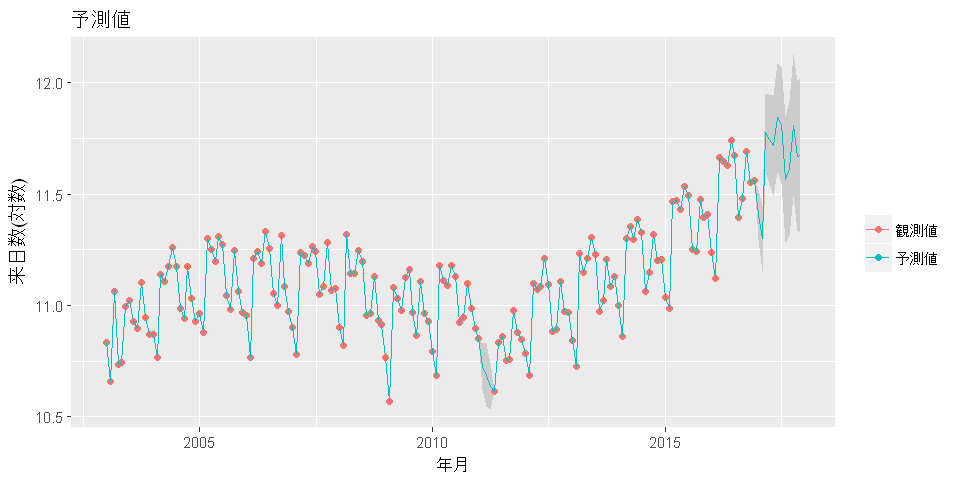

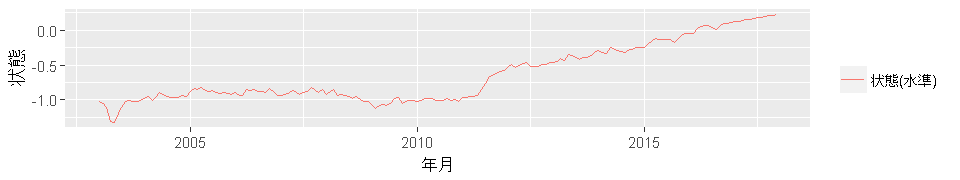

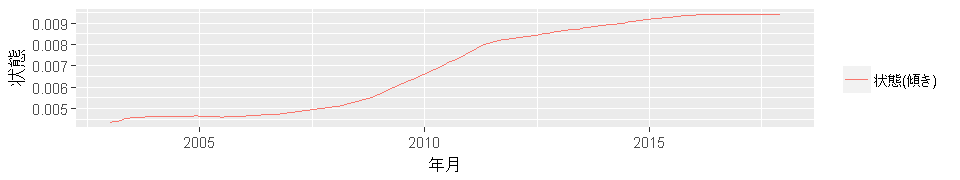

Warning message:
"Removed 12 rows containing missing values (geom_path)."

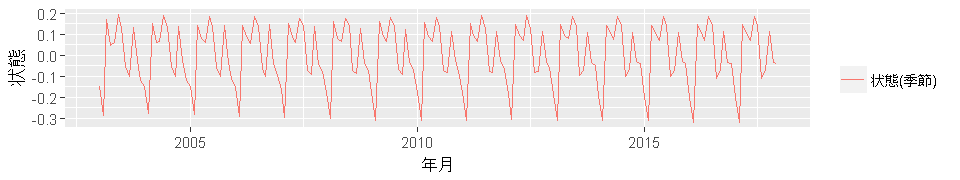

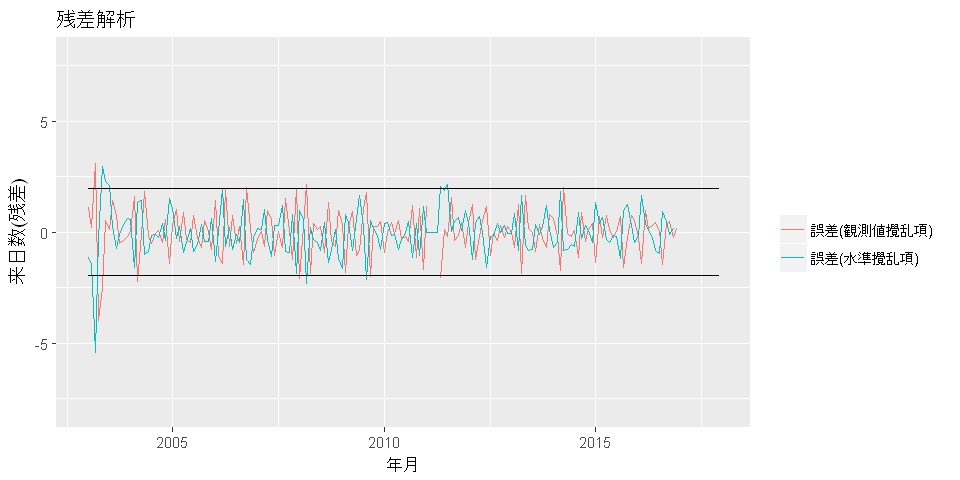

In [312]:
# ベストモデルの情報を含むdata.frameを作成
df.best <- data.frame(年月=datetime.NA,観測値=obj.NA,best.conf,best.predict,best.error,kfs[[best_idx]]$alphahat,
                    x=c(-Inf,Inf),lb=-1.96,ub=1.96)
# 予測値
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best,aes(x=年月)) + 
    geom_ribbon(aes(ymin=lwr.1,ymax=upr.1),fill="grey90") +
    geom_ribbon(aes(ymin=lwr,ymax=upr),fill="grey80") +
    geom_point(aes(y=観測値,color="観測値")) +
    geom_line(aes(y=fit,color="予測値")) +
    xlab("年月") + ylab("来日数(対数)") + ggtitle("予測値") + labs(color="")
# 状態変化
options(repr.plot.width=8, repr.plot.height=1.5)
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=level-12,color="状態(水準)")) + ylab("状態") + labs(color="")
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=slope,color="状態(傾き)")) + ylab("状態") + labs(color="")
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=sea_dummy1,color="状態(季節)")) + ylab("状態") + labs(color="")

# 残差解析
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best,aes(x=年月)) + 
    geom_line(aes(y=state_err.level,color="誤差(水準攪乱項)")) + 
    geom_line(aes(y=obs_err,color="誤差(観測値攪乱項)")) + 
    geom_line(aes(y=state_err.level,color="誤差(水準攪乱項)")) + 
    geom_line(aes(y=lb)) + geom_line(aes(y=ub)) + 
    xlab("年月") + ylab("来日数(残差)") + ggtitle("残差解析") + labs(color="") + ylim(-8,8)


In [313]:
kfs[[best_idx]]$alphahat %>% head

eq,level,slope,sea_dummy1,sea_dummy2,sea_dummy3,sea_dummy4,sea_dummy5,sea_dummy6,sea_dummy7,sea_dummy8,sea_dummy9,sea_dummy10,sea_dummy11
-0.5108847,10.98312,0.004352783,-0.14818209,-0.12413974,-0.02640536,0.13398166,-0.09915699,-0.05185532,0.12740322,0.19485781,0.06212667,0.04622275,0.17056925
-0.5108847,10.94425,0.004361197,-0.28542186,-0.14818209,-0.12413974,-0.02640536,0.13398166,-0.09915699,-0.05185532,0.12740322,0.19485781,0.06212667,0.04622275
-0.5108847,10.89360,0.004380317,0.17056925,-0.28542186,-0.14818209,-0.12413974,-0.02640536,0.13398166,-0.09915699,-0.05185532,0.12740322,0.19485781,0.06212667
-0.5108847,10.68833,0.004440244,0.04622275,0.17056925,-0.28542186,-0.14818209,-0.12413974,-0.02640536,0.13398166,-0.09915699,-0.05185532,0.12740322,0.19485781
-0.5108847,10.68256,0.004502159,0.06212667,0.04622275,0.17056925,-0.28542186,-0.14818209,-0.12413974,-0.02640536,0.13398166,-0.09915699,-0.05185532,0.12740322
-0.5108847,10.80248,0.004541608,0.19485781,0.06212667,0.04622275,0.17056925,-0.28542186,-0.14818209,-0.12413974,-0.02640536,0.13398166,-0.09915699,-0.05185532


* 大震災による外れ値の影響が改善され，予測値の信頼区間の幅も小さくなっていることが確認できる

#### 参考：地震項なし(モデル4，平滑化トレンド(水準変動あり)＋周期性(季節変動あり))の結果

In [314]:
best_idx = 4
#　信頼区間(状態)
best.conf <- predict(mods.fit[[best_idx]],interval="confidence",level=.95)
# 信頼区間(観測値)
best.predict <- predict(mods.fit[[best_idx]],interval="prediction",level=.95)
# 残差
best.error <- get_standardized_error(kfs[[best_idx]])

Warning message:
"Removed 15 rows containing missing values (geom_point)."

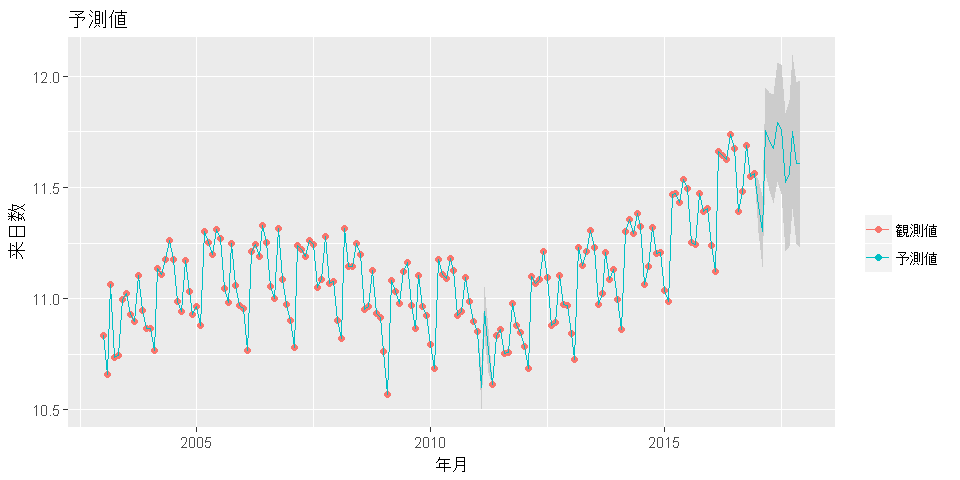

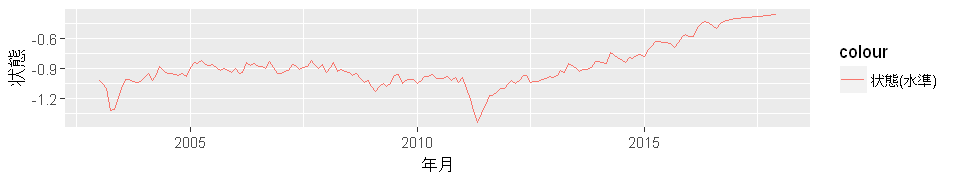

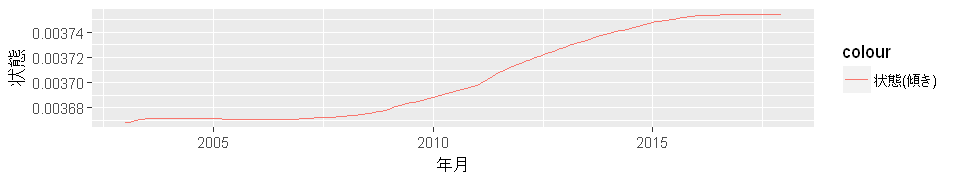

Warning message:
"Removed 12 rows containing missing values (geom_path)."

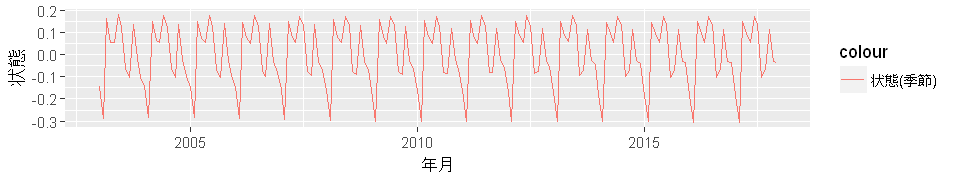

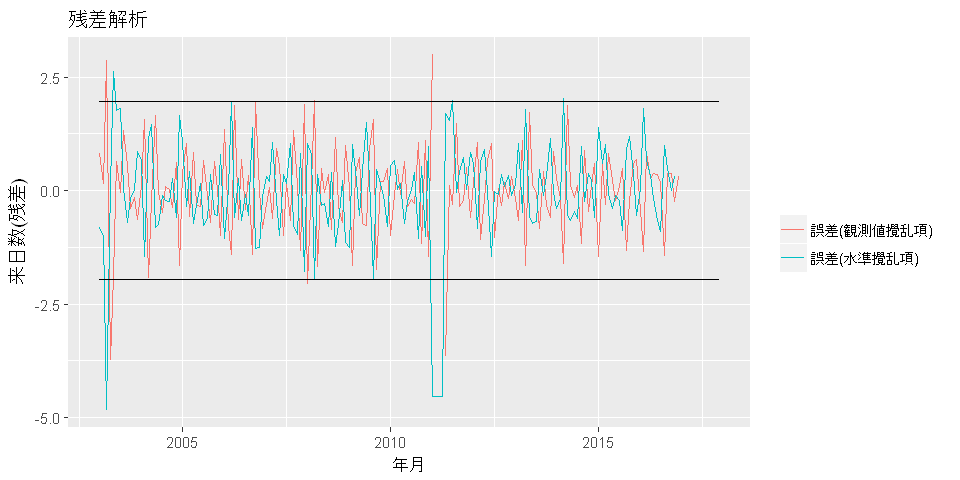

In [315]:
# ベストモデルの情報を含むdata.frameを作成
df.best <- data.frame(年月=datetime.NA,観測値=obj.NA,best.conf,best.predict,best.error,kfs[[best_idx]]$alphahat,
                    x=c(-Inf,Inf),lb=-1.96,ub=1.96)
# 予測値
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best,aes(x=年月)) + 
    geom_ribbon(aes(ymin=lwr.1,ymax=upr.1),fill="grey90") +
    geom_ribbon(aes(ymin=lwr,ymax=upr),fill="grey80") +
    geom_point(aes(y=観測値,color="観測値")) +
    geom_line(aes(y=fit,color="予測値")) +
    xlab("年月") + ylab("来日数") + ggtitle("予測値") + labs(color="")
# 状態変化
options(repr.plot.width=8, repr.plot.height=1.5)
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=level-12,color="状態(水準)")) + ylab("状態")
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=slope,color="状態(傾き)")) + ylab("状態")
ggplot(df.best,aes(x=年月)) + geom_line(aes(y=sea_dummy1,color="状態(季節)")) + ylab("状態")

# 残差解析
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best,aes(x=年月)) + 
    geom_line(aes(y=state_err.level,color="誤差(水準攪乱項)")) + 
    geom_line(aes(y=obs_err,color="誤差(観測値攪乱項)")) + 
    geom_line(aes(y=state_err.level,color="誤差(水準攪乱項)")) + 
    geom_line(aes(y=lb)) + geom_line(aes(y=ub)) + 
    xlab("年月") + ylab("来日数(残差)") + ggtitle("残差解析") + labs(color="")


### 提出用

Warning message:
"Removed 15 rows containing missing values (geom_point)."

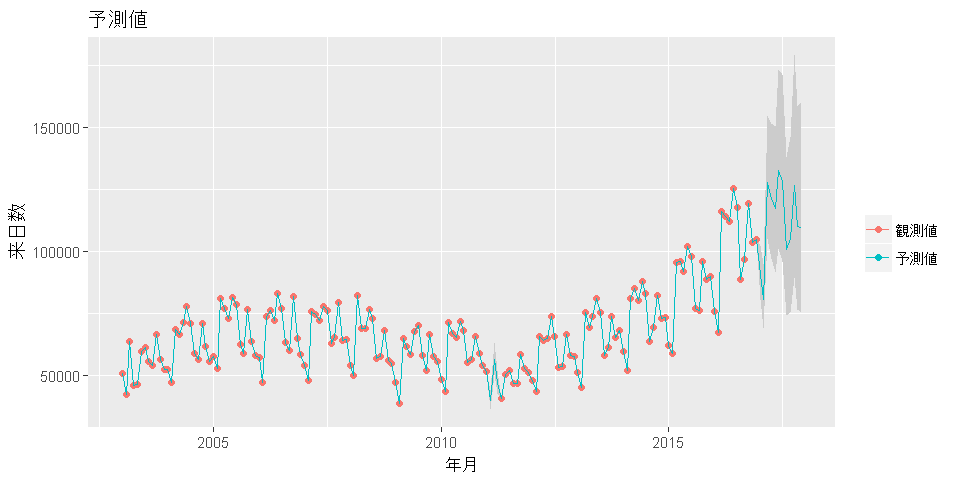

In [316]:
# 元のスケールに戻す
df.best.exp <- df.best
df.best.exp[,-1] <- exp(df.best[,-1])

# 予測値
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df.best.exp,aes(x=年月)) + 
    geom_ribbon(aes(ymin=lwr,ymax=upr),fill="grey60") +
    geom_ribbon(aes(ymin=lwr.1,ymax=upr.1),fill="grey80") +
    geom_point(aes(y=観測値,color="観測値")) +
    geom_line(aes(y=fit,color="予測値")) +
    xlab("年月") + ylab("来日数") + ggtitle("予測値") + labs(color="")

# plot_ly(df.best.exp) %>% 
#     # 実測値
#     add_markers(x = datetime.NA, y = ~obj.NA, name = "観測値", color = I("blue")) %>% 
#     # 信頼区間(状態)
#     add_ribbons(x = datetime.NA, ymin = ~lwr, ymax = ~upr, name = "95% 信頼区間(状態)", color = I("gray80")) %>% 
#     # 信頼区間(観測値)
#     add_ribbons(x = datetime.NA, ymin = ~lwr.1, ymax = ~upr.1, name = "95% 信頼区間(観測値)", color = I("gray95")) %>% 
#     # 予測値
#     add_lines(x = datetime.NA, y = ~fit, name = "prediction", color = I("black")) %>% 
#     layout(yaxis=list(title="訪問者数"))

In [317]:
idx2017 <- which(datetime.NA == as.Date("2017-01-01")) : which(datetime.NA == as.Date("2017-12-01"))
print("2017年米国の訪問者数期待値(単位：人)：")
df.best.exp$fit[idx2017]  %>% as.integer %>% as.list

[1] "2017年米国の訪問者数期待値(単位：人)："


[[1]]
[1] 90898

[[2]]
[1] 80839

[[3]]
[1] 127677

[[4]]
[1] 121472

[[5]]
[1] 117357

[[6]]
[1] 132471

[[7]]
[1] 128251

[[8]]
[1] 101003

[[9]]
[1] 105087

[[10]]
[1] 126755

[[11]]
[1] 110115

[[12]]
[1] 109838

# 番外編: bstsパッケージ
* ベイジアン構造時系列モデリングを扱うことの出来る、bstsパッケージによる分析を行う
    * カルマンフィルタ(行列演算)による推定ではなく、MCMCによる推定を行う  
    →**非ガウシアン状態空間モデルを扱うことが出来る**
    * 特筆すべき点として、lassoのような、**説明変数の選択機能が内蔵**されている  
    各回帰係数にspike-and-slab分布を仮定することで、スパースな結果が得られる  
    今回は説明変数が少ないため効果は薄いが、候補が大量にあるケースでは有用であると考えられる
* 参考：
    * [[R] bsts パッケージの使い方](http://ill-identified.hatenablog.com/entry/2017/09/08/001002)

In [318]:
library(bsts)
set.seed(1234)

### 外れ値除去前
* KFASパッケージの分析時と同様、まずは外れ値を除去しない状態で分析してみる
* 下記２つのモデルの推定を行い、結果を比較する
    * 平滑化トレンド＋季節変動
    * 平滑化トレンド＋季節変動＋カレンダー効果
* この段階では地震項は考慮しない

In [319]:
# bstsパッケージ用にdata.frameを作成
# Note:　後のプロットのため、観測値を標準化する
datetime_index <- 1:length(datetime)
obj.bsts <- data.frame(
    y=scale(obj),
    leapyear = calendar$leapyear[datetime_index],
    calendar = calendar$calendar[datetime_index,])

# 状態空間モデルの定義(平滑化トレンド＋季節変動)
ss <- AddLocalLinearTrend(state.specification=list(),obj.bsts$y)
ss <- AddSeasonal(ss,obj.bsts$y,nseasons=12)

In [320]:
# モデルの定義とサンプリングの実施

bsts_mods <- list(
    #　平滑化トレンド + 季節変動
    bsts(obj.bsts$y,
            state.specification = ss,
            niter = 10000),
    # 平滑化トレンド + 季節変動 + 説明変数（カレンダー）
    bsts(y~.,
         state.specification = ss,
         niter = 10000,
         data = obj.bsts
    )
)

=-=-=-=-= Iteration 0 Tue Feb 27 20:45:34 2018
 =-=-=-=-=
=-=-=-=-= Iteration 1000 Tue Feb 27 20:45:37 2018
 =-=-=-=-=
=-=-=-=-= Iteration 2000 Tue Feb 27 20:45:40 2018
 =-=-=-=-=
=-=-=-=-= Iteration 3000 Tue Feb 27 20:45:42 2018
 =-=-=-=-=
=-=-=-=-= Iteration 4000 Tue Feb 27 20:45:45 2018
 =-=-=-=-=
=-=-=-=-= Iteration 5000 Tue Feb 27 20:45:48 2018
 =-=-=-=-=
=-=-=-=-= Iteration 6000 Tue Feb 27 20:45:50 2018
 =-=-=-=-=
=-=-=-=-= Iteration 7000 Tue Feb 27 20:45:53 2018
 =-=-=-=-=
=-=-=-=-= Iteration 8000 Tue Feb 27 20:45:56 2018
 =-=-=-=-=
=-=-=-=-= Iteration 9000 Tue Feb 27 20:45:59 2018
 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Feb 27 20:46:02 2018
 =-=-=-=-=
=-=-=-=-= Iteration 1000 Tue Feb 27 20:46:05 2018
 =-=-=-=-=
=-=-=-=-= Iteration 2000 Tue Feb 27 20:46:07 2018
 =-=-=-=-=
=-=-=-=-= Iteration 3000 Tue Feb 27 20:46:10 2018
 =-=-=-=-=
=-=-=-=-= Iteration 4000 Tue Feb 27 20:46:13 2018
 =-=-=-=-=
=-=-=-=-= Iteration 5000 Tue Feb 27 20:46:16 2018
 =-=-=-=-=
=-=-=-=-= Iteration 6000 Tue F

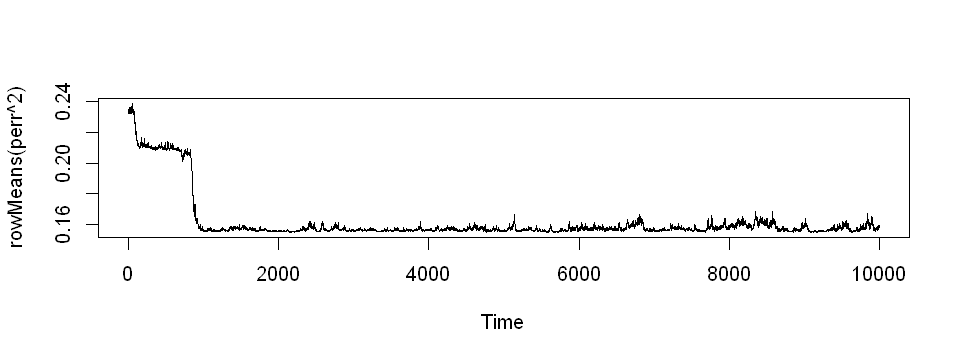

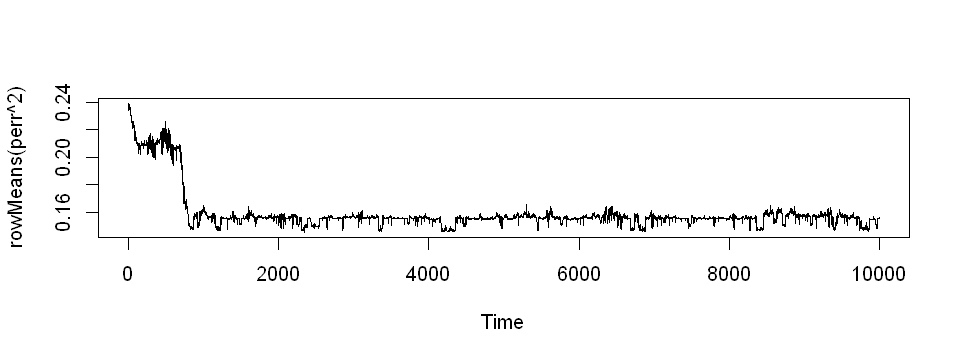

In [321]:
# 収束チェック
options(repr.plot.width=8, repr.plot.height=3)
perr <- bsts_mods[[1]]$one.step.prediction.errors
ts.plot(rowMeans(perr^2))
perr <- bsts_mods[[2]]$one.step.prediction.errors
ts.plot(rowMeans(perr^2))

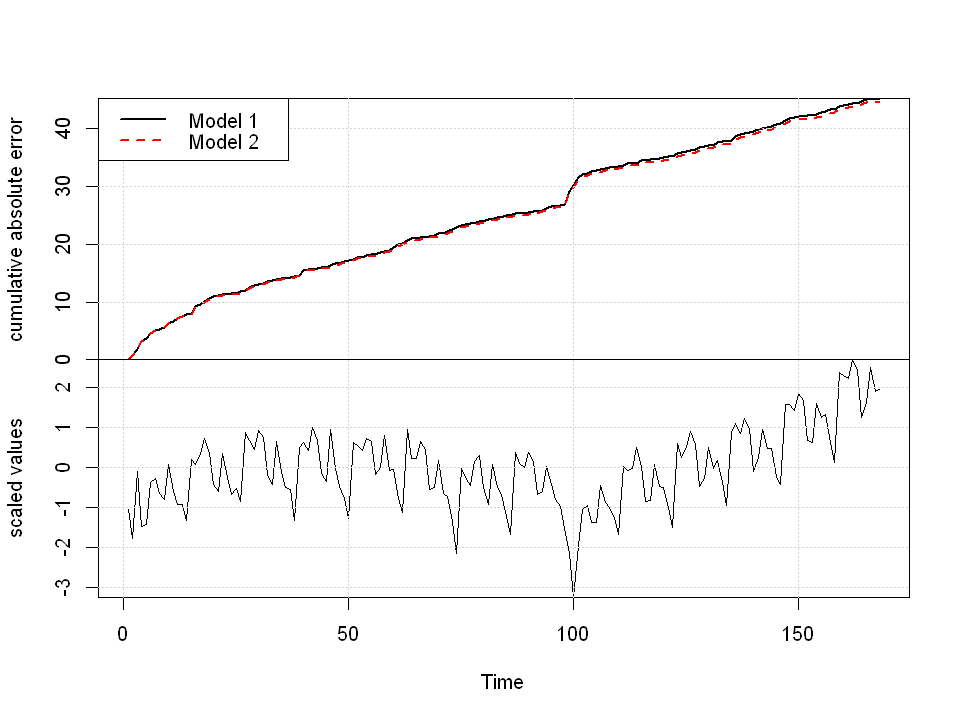

In [322]:
# 残差分析
options(repr.plot.width=8, repr.plot.height=6)
CompareBstsModels(bsts_mods)

* １期先予測値の誤差の累積値をプロット
* 震災後に誤差が大きく上昇し、大震災の影響が無視できないことがわかる
* 次に、外れ値を除去し、地震項を追加したモデルで分析を行う
* メモ：burn-in期間は内部でSuggestBurn()が実行され，イイ感じのMCMCサンプルのみを使ってくれる

### 外れ値除去

In [323]:
# Note:　後のプロットのため、観測値を標準化する
datetime_index <- 1:length(datetime)
obj.bsts.NA <- data.frame(
    y = scale(obj.NA)[datetime_index,],
    eq = eq[datetime_index],
    leapyear = calendar$leapyear[datetime_index],
    calendar = calendar$calendar[datetime_index,]
)

# 状態空間モデルの定義(平滑化トレンド＋季節変動)
ss <- AddLocalLinearTrend(state.specification=list(),obj.bsts.NA$y)
ss <- AddSeasonal(ss,obj.bsts.NA$y,nseasons=12)
ss_ar2 <- AddAutoAr(ss, obj.bsts.NA$y,lags=2)

In [324]:
# モデルの定義とサンプリングの実施

bsts_mods <- list(
    #　平滑化トレンド + 季節変動
    bsts(obj.bsts.NA$y,
            state.specification = ss,
            niter = 10000),
    # 平滑化トレンド + 季節変動 + 説明変数（カレンダー、地震）
    bsts(y~.,
         state.specification = ss,
         niter = 10000,
         data = obj.bsts.NA
    )
)

=-=-=-=-= Iteration 0 Tue Feb 27 20:46:31 2018
 =-=-=-=-=
=-=-=-=-= Iteration 1000 Tue Feb 27 20:46:33 2018
 =-=-=-=-=
=-=-=-=-= Iteration 2000 Tue Feb 27 20:46:36 2018
 =-=-=-=-=
=-=-=-=-= Iteration 3000 Tue Feb 27 20:46:39 2018
 =-=-=-=-=
=-=-=-=-= Iteration 4000 Tue Feb 27 20:46:42 2018
 =-=-=-=-=
=-=-=-=-= Iteration 5000 Tue Feb 27 20:46:44 2018
 =-=-=-=-=
=-=-=-=-= Iteration 6000 Tue Feb 27 20:46:47 2018
 =-=-=-=-=
=-=-=-=-= Iteration 7000 Tue Feb 27 20:46:50 2018
 =-=-=-=-=
=-=-=-=-= Iteration 8000 Tue Feb 27 20:46:53 2018
 =-=-=-=-=
=-=-=-=-= Iteration 9000 Tue Feb 27 20:46:55 2018
 =-=-=-=-=
=-=-=-=-= Iteration 0 Tue Feb 27 20:46:58 2018
 =-=-=-=-=
=-=-=-=-= Iteration 1000 Tue Feb 27 20:47:01 2018
 =-=-=-=-=
=-=-=-=-= Iteration 2000 Tue Feb 27 20:47:04 2018
 =-=-=-=-=
=-=-=-=-= Iteration 3000 Tue Feb 27 20:47:07 2018
 =-=-=-=-=
=-=-=-=-= Iteration 4000 Tue Feb 27 20:47:10 2018
 =-=-=-=-=
=-=-=-=-= Iteration 5000 Tue Feb 27 20:47:13 2018
 =-=-=-=-=
=-=-=-=-= Iteration 6000 Tue F

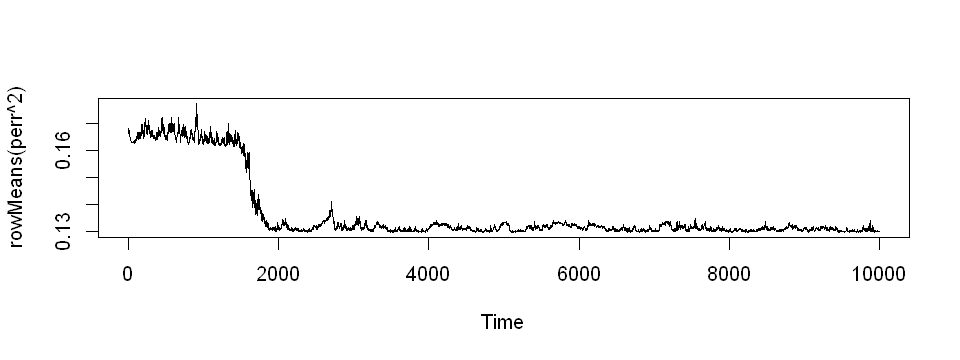

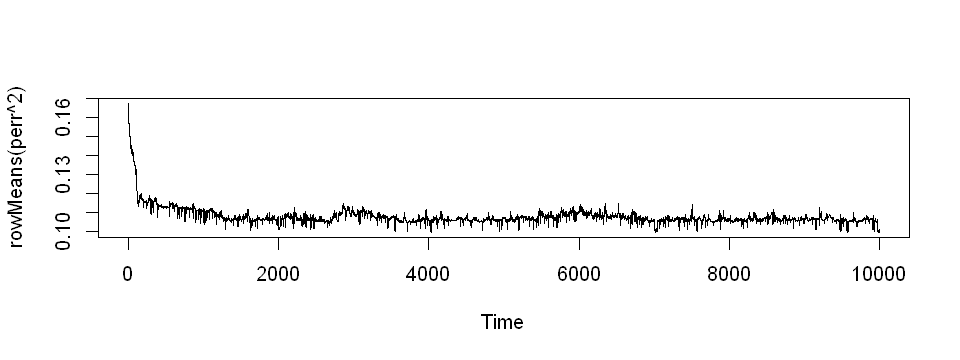

In [325]:
# 収束チェック
options(repr.plot.width=8, repr.plot.height=3)
perr <- bsts_mods[[1]]$one.step.prediction.errors
ts.plot(rowMeans(perr^2))
perr <- bsts_mods[[2]]$one.step.prediction.errors
ts.plot(rowMeans(perr^2))

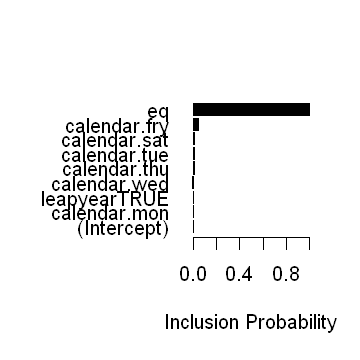

In [326]:
# 各係数のモデルに含まれる確率
options(repr.plot.width=3, repr.plot.height=3)
plot(bsts_mods[[2]],"coef")

* カレンダー効果，地震項共に選択される確率は低い
→カレンダー効果はKFASの分析結果と同等である
→KFASの結果においては地震項があった方がわずかにAICは良かったが，無くてもほとんど変わらなかった

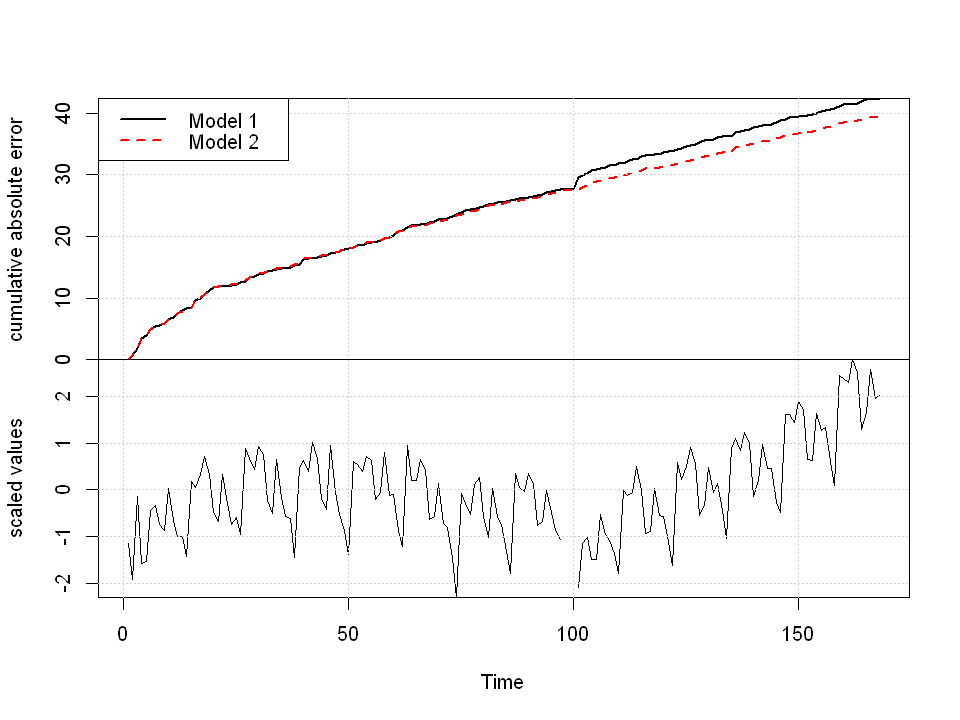

In [327]:
options(repr.plot.width=8, repr.plot.height=6)
CompareBstsModels(bsts_mods)

* 外れ値除去により、累積誤差が改善された
* 震災前では、２つのモデルに大きな差は見られない。  
一方震災後の累積誤差を比較すると、以下のことがわかる。
  * 地震項を加えたモデル(Model２)では震災直後のデータから当てはまりが良い
  * 説明変数なしモデル（Model1）では震災直後で誤差がステップ状に増加し、また累積誤差の上昇もより早い
* すなわち、震災前と後では傾向が変化しており、ローカルレベルと傾きを緩やかに変化させるだけでは、  
その後のデータにうまく追従できないことを表している

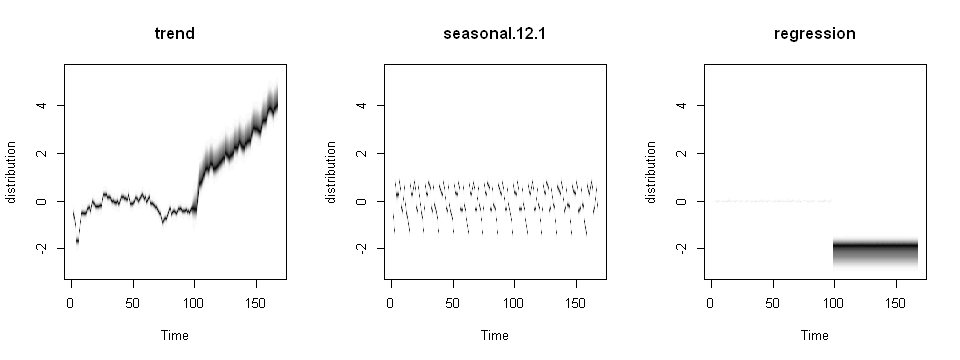

In [328]:
# 各状態のプロット
options(repr.plot.width=8, repr.plot.height=3)
plot(bsts_mods[[2]],"comp")

### 予測

In [329]:
pred <- predict(bsts_mods[[2]], burn=3000, newdata=data.frame(eq=eq,leapyear=calendar$leapyear,calendar=calendar$calendar)[(length(eq)-11):length(eq),])

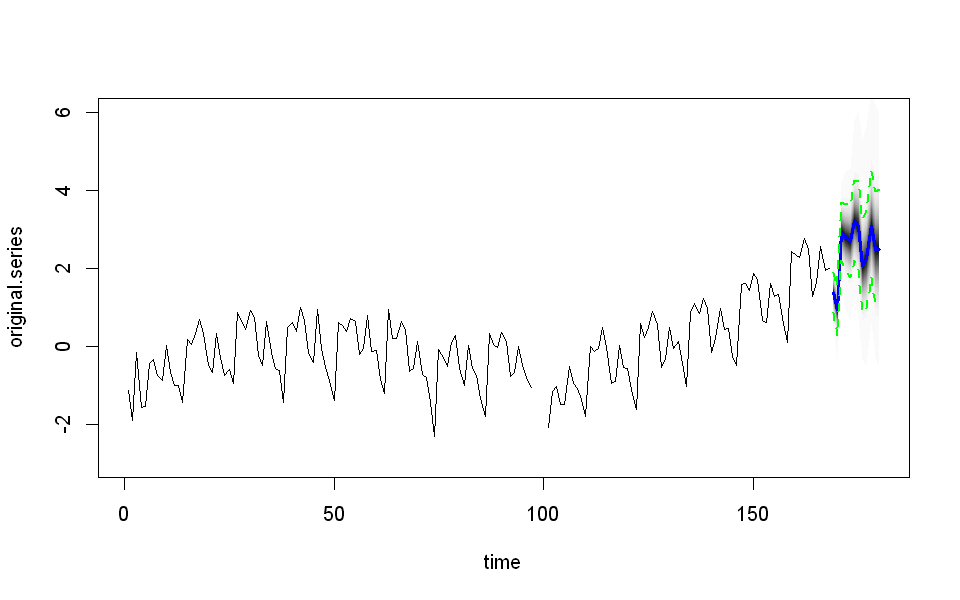

In [330]:
options(repr.plot.width=8, repr.plot.height=5)
plot(pred,ylim=c(-3,6))

## memo
* 複数国対象はできない？？
* seasonal入れるとfitの結果がNAになるが…。

In [331]:

obj <- df_log[,c(14,15)]  # 複数国対象
obj.NA <- rbind(obj %>% as.matrix,matrix(NA,12,dim(obj)[2]))
# obj.NA <- ts(obj)

# モデル
mod <- SSModel(obj.NA ~ SSMtrend(1,Q=matrix(NA,2,2)),H=matrix(NA,2,2))
# パラメータ推定
fit <- fitSSM(mod,numeric(6),method="BFGS")
# カルマンスムージング
kf <- KFS(fit$model)
# 予測
obj.conf <- predict(fit$model,interval="confidence",level=.95)

In [332]:
# プロット
df.conf1 <- data.frame(obj.NA,obj.conf[[1]])
plot_ly(df.conf1) %>% 
    add_markers(x = datetime.NA, y = ~obj.NA[,1], name = "observed", color = I("blue")) %>% 
    add_ribbons(x = datetime.NA, ymin = ~lwr, ymax = ~upr, name = "95% confidence", color = I("gray95")) %>% 
    add_lines(x = datetime.NA, y = ~fit, name = "prediction", color = I("black")) %>% 
    layout(yaxis=list(title="訪問者数(log)"))

df.conf2 <- data.frame(obj.NA,obj.conf[[2]])
plot_ly(df.conf2) %>% 
    add_markers(x = datetime.NA, y = ~obj.NA[,2], name = "observed", color = I("blue")) %>% 
    add_ribbons(x = datetime.NA, ymin = ~lwr, ymax = ~upr, name = "95% confidence", color = I("gray95")) %>% 
    add_lines(x = datetime.NA, y = ~fit, name = "prediction", color = I("black")) %>% 
    layout(yaxis=list(title="訪問者数(log)"))

Warning message:
"Ignoring 12 observations"ERROR while rich displaying an object: Error in htmlwidgets::saveWidget(obj, htmlfile): Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.htmlwidget(obj)
9. htmlwidgets::saveWidget(obj, htmlfile)
10. stop("Saving a widget with selfcontained = 

HTML widgets cannot be represented in plain text (need html)

Warning message:
"Ignoring 12 observations"ERROR while rich displaying an object: Error in htmlwidgets::saveWidget(obj, htmlfile): Saving a widget with selfcontained = TRUE requires pandoc. For details see:
https://github.com/rstudio/rmarkdown/blob/master/PANDOC.md

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     rpr <- mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. mime2repr[[mime]](obj)
8. repr_html.htmlwidget(obj)
9. htmlwidgets::saveWidget(obj, htmlfile)
10. stop("Saving a widget with selfcontained = 

HTML widgets cannot be represented in plain text (need html)